# Bank marketing UCI EDA

### Attribute Information:

##### Bank client data:
* 1 - age (numeric)
* 2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
* 3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
* 4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
* 5 - default: has credit in default? (categorical: 'no','yes','unknown')
* 6 - housing: has housing loan? (categorical: 'no','yes','unknown')
* 7 - loan: has personal loan? (categorical: 'no','yes','unknown')

##### Related with the last contact of the current campaign:
* 8 - contact: contact communication type (categorical: 'cellular','telephone')
* 9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
* 10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
* 11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.

##### Other attributes:
* 12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
* 13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
* 14 - previous: number of contacts performed before this campaign and for this client (numeric)
* 15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')

##### Social and economic context attributes
* 16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
* 17 - cons.price.idx: consumer price index - monthly indicator (numeric)
* 18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)
* 19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
* 20 - nr.employed: number of employees - quarterly indicator (numeric)

##### Output variable (desired target):
* 21 - y - has the client subscribed a term deposit? (binary: 'yes','no')

In [121]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import recall_score
from sklearn.model_selection import cross_validate

In [229]:
def read_data(path: str, files: list):
    dataframes = []
    for file in files:
        dataframes.append(pd.read_csv(path + file, sep=';'))
    return dataframes


path = '../data/bank-additional/'
files = ['bank-additional-full.csv']
bank_data = read_data(path, files)[0]

### General

In [206]:
bank_data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [207]:
bank_data.shape

(41188, 21)

* Let's check missing values

In [208]:
bank_data.isnull().sum()

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64

* No missing values

* Let's check duplicates and remove them if there are some

In [209]:
bank_data.duplicated().sum()

12

* Twelve duplicates, so let's remove them

In [210]:
bank_data.drop_duplicates(inplace=True)
bank_data.duplicated().sum()

0

In [211]:
bank_data.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41176.00000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000
mean,40.02380,258.315815,2.567879,962.464810,0.173013,0.081922,93.575720,-40.502863,3.621293,5167.034870
std,10.42068,259.305321,2.770318,186.937102,0.494964,1.570883,0.578839,4.627860,1.734437,72.251364
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


### Distributions

In [230]:
def encode_bool(features, data):
    for feature in features:
        data[feature] = data[feature].map({'yes': 1, 'no': 0, 'unknown': 'unknown'})
    display(data.sample(5))

    
bool_features = ['default', 'housing', 'loan', 'y']
encode_bool(bool_features, bank_data)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
33236,45,admin.,married,university.degree,0,1,1,cellular,may,tue,...,1,999,0,nonexistent,-1.8,92.893,-46.2,1.291,5099.1,1
21841,32,management,married,university.degree,0,0,0,cellular,aug,wed,...,1,999,0,nonexistent,1.4,93.444,-36.1,4.964,5228.1,0
37544,62,retired,married,unknown,0,0,0,cellular,aug,fri,...,4,999,0,nonexistent,-2.9,92.201,-31.4,0.869,5076.2,1
7744,37,unemployed,married,professional.course,0,0,0,telephone,may,fri,...,8,999,0,nonexistent,1.1,93.994,-36.4,4.864,5191.0,0
17561,39,admin.,single,high.school,0,0,0,cellular,jul,mon,...,7,999,0,nonexistent,1.4,93.918,-42.7,4.962,5228.1,0


In [254]:
def create_countplot(feature, hue, fontsize, data):
    sns.set(style="darkgrid")
    plt.figure(figsize=(15, 6))
    ax = sns.countplot(x=feature, hue=hue, data=data)
    plt.title('{} distribution'.format(feature.capitalize()))
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height() / float(len(data)))
        x = p.get_x() + p.get_width() / 2
        y = p.get_height() / 2
        ax.annotate(percentage, xy=(x, y), fontsize=fontsize, ha='center', va='center')
    plt.show()

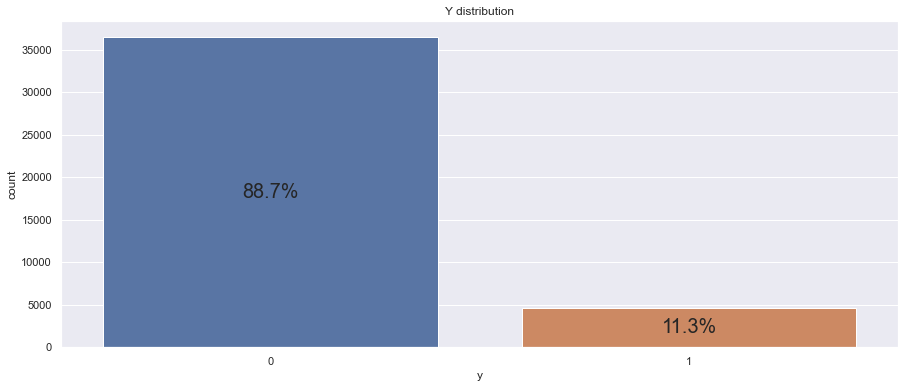

In [232]:
create_countplot(feature='y', hue=None, fontsize=20, data=bank_data)

* 'no' is prevailed value in target feature 'y'

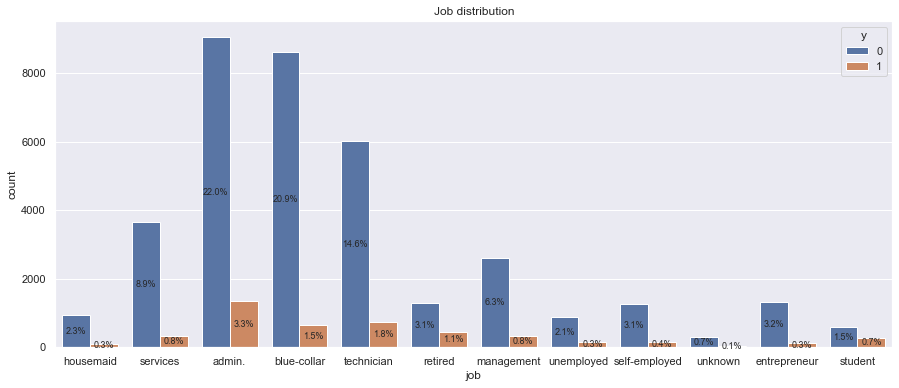

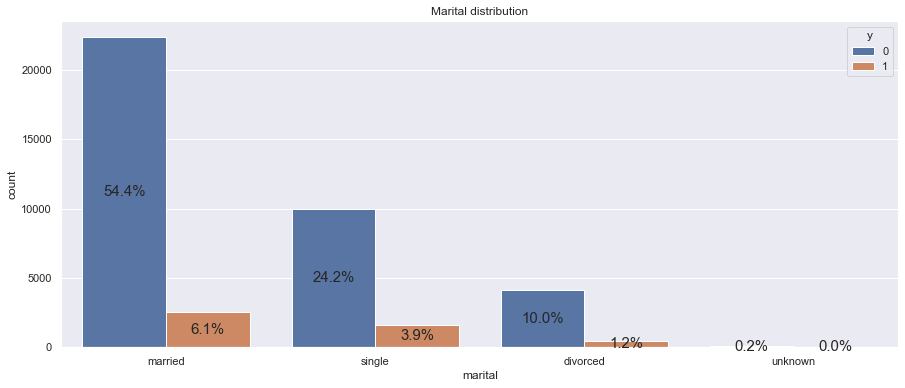

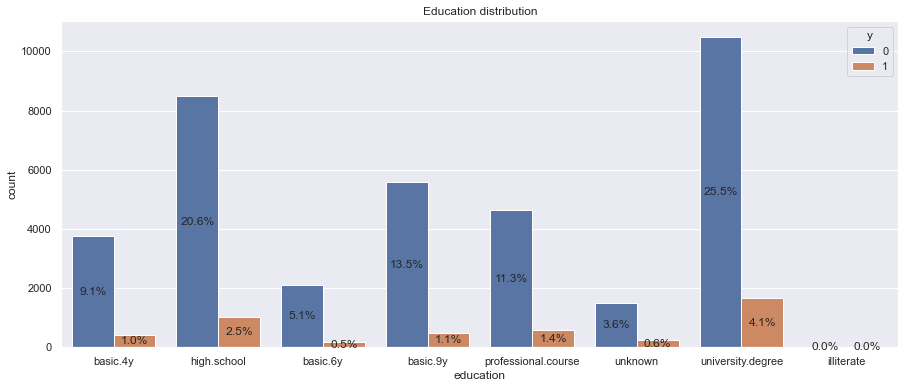

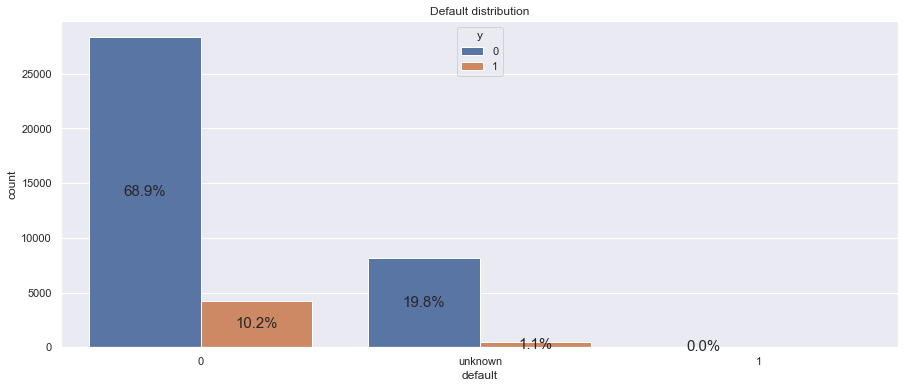

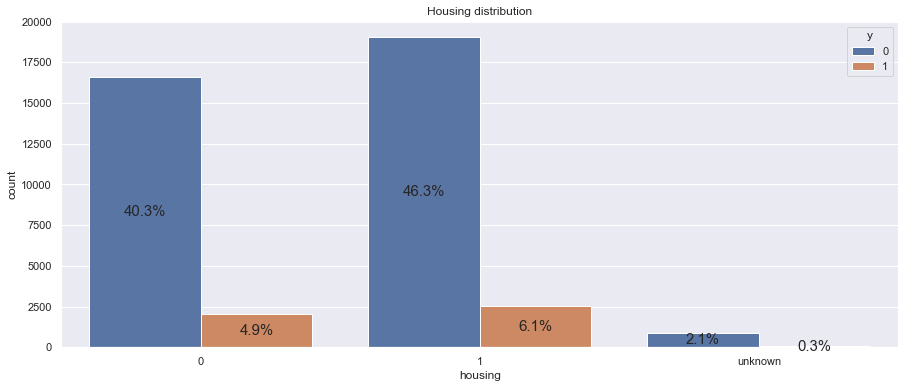

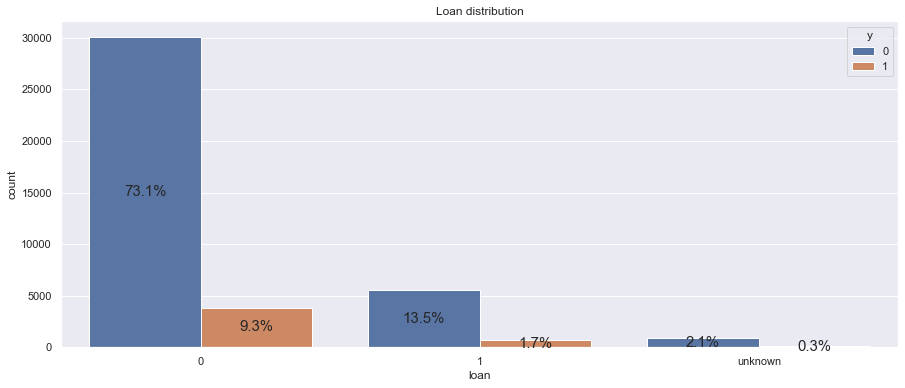

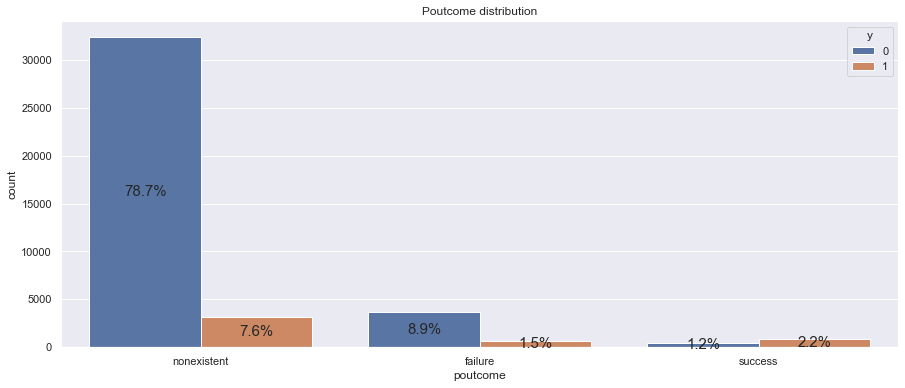

In [233]:
categorical = {'job': 9, 'marital': 15, 'education': 12, 'default': 15, 'housing': 15, 'loan': 15, 'poutcome': 15}
for cat, fontsize in categorical.items():
    create_countplot(feature=cat, hue='y', fontsize=fontsize, data=bank_data)

In [234]:
def create_hist(feature, minimum=-np.inf, maximum=np.inf):
    fig = plt.figure(figsize=(15, 7))
    plt.style.use('seaborn-deep')
    plt.hist(bank_data[(bank_data['y'] == 1) & (bank_data[feature] >= minimum) & (bank_data[feature] <= maximum)][feature], 
             alpha=0.9, label='y=1', bins=35)
    plt.hist(bank_data[(bank_data['y'] == 0) & (bank_data[feature] >= minimum) & (bank_data[feature] <= maximum)][feature], 
             alpha=0.6, label='y=0', bins=35)
    plt.legend(loc='upper right')
    plt.title('{} distribution'.format(feature.capitalize()))

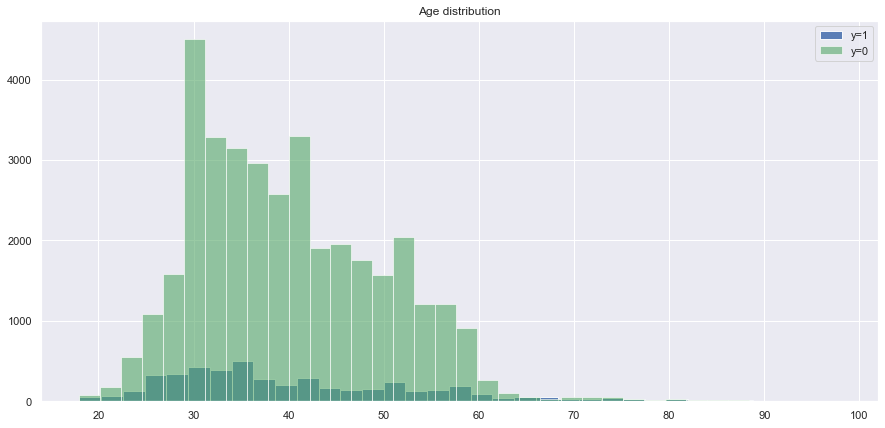

In [235]:
create_hist('age', 18, 100)

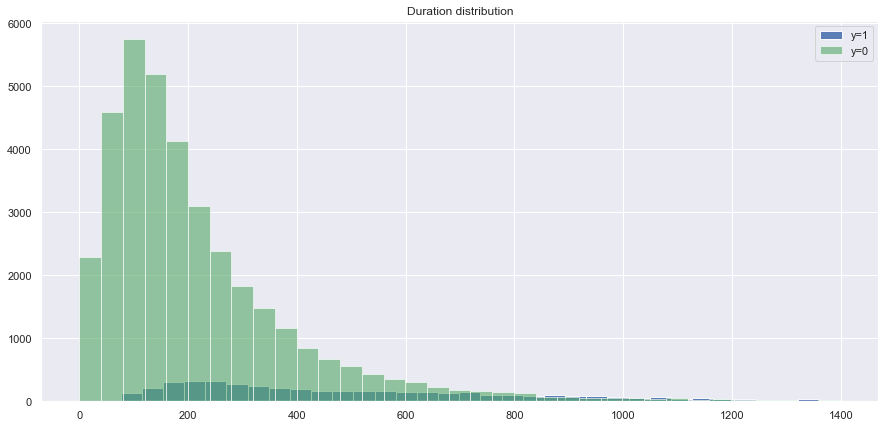

In [236]:
create_hist('duration', 0, 1400)

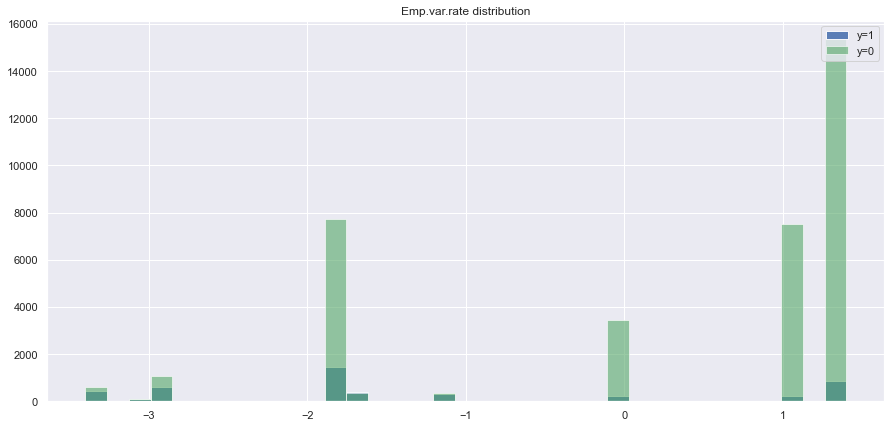

In [237]:
create_hist('emp.var.rate')

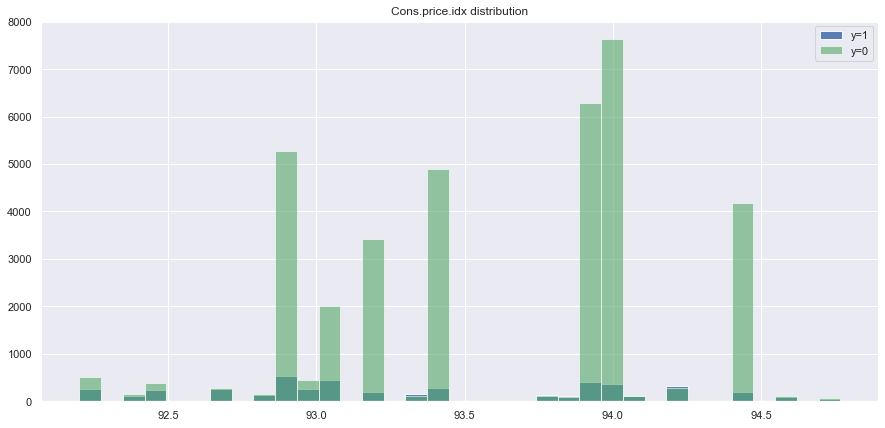

In [239]:
create_hist('cons.price.idx')

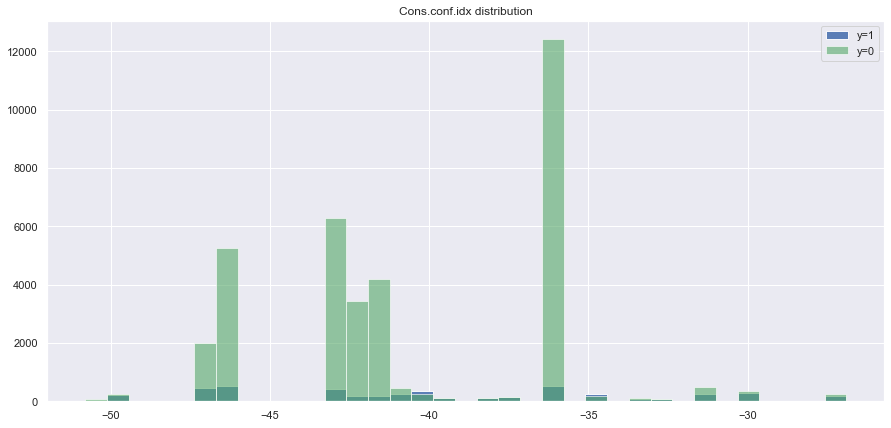

In [240]:
create_hist('cons.conf.idx')

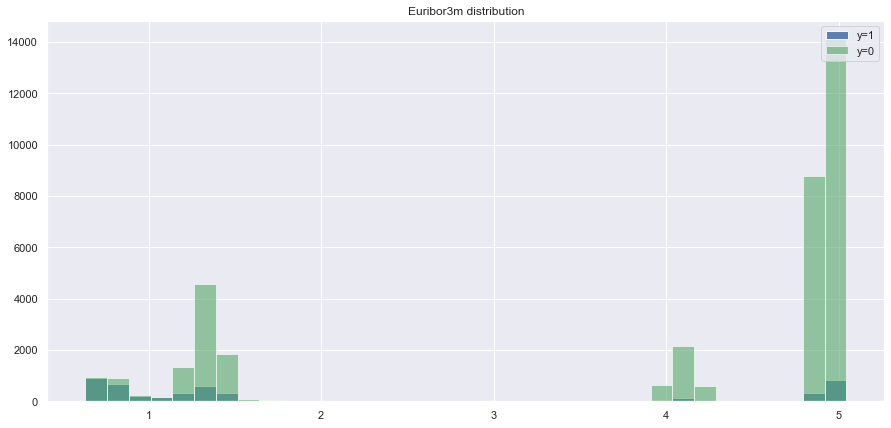

In [243]:
create_hist('euribor3m')

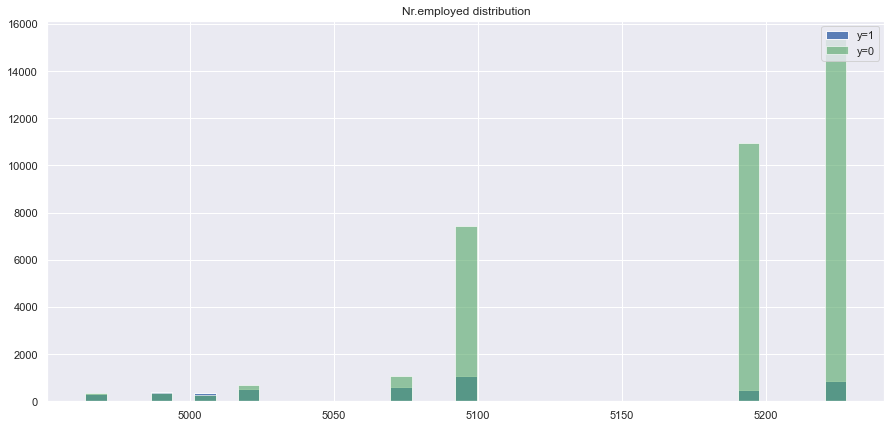

In [245]:
create_hist('nr.employed')

* Let's create timeseries month feature

In [273]:
def create_ts_month(data):
    months = ['may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec', 'jan', 'feb', 'mar', 'apr']
    i = 0
    
    idx = data.index[data['month'] == 'apr'][0] - 1
    first = data.loc[:idx]
    for month in months:
        if len(first[first['month'] == month]):
            first.loc[first['month'] == month, 'ts_month'] = i
            i += 1
    
    months = ['apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec', 'jan', 'feb', 'mar']
    data = data.loc[idx + 1:]
    idx = data.index[(data['month'] == 'mar')][0] - 1
    second = data.loc[:idx]
    for month in months:
        if len(second[second['month'] == month]):
            second.loc[second['month'] == month, 'ts_month'] = i
            i += 1
            
    months = ['mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov']
    third = data.loc[idx + 1:]
    for month in months:
        if len(third[third['month'] == month]):
            third.loc[third['month'] == month, 'ts_month'] = i
            i += 1
            
    return pd.concat([first, second, third], ignore_index=True)
    
    
bank_data = create_ts_month(bank_data)
bank_data.ts_month = bank_data.ts_month.astype('int8')
bank_data.sample(10)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,ts_month
31144,36,management,married,basic.9y,0,1,0,cellular,may,wed,...,999,1,failure,-1.8,92.893,-46.2,1.334,5099.1,0,9
18481,38,services,married,high.school,0,1,0,telephone,jul,thu,...,999,0,nonexistent,1.4,93.918,-42.7,4.968,5228.1,0,2
40186,51,admin.,married,university.degree,0,0,1,cellular,jul,fri,...,999,0,nonexistent,-1.7,94.215,-40.3,0.861,4991.6,0,21
109,43,technician,married,unknown,unknown,1,1,telephone,may,mon,...,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,0
25300,36,management,married,university.degree,0,1,0,cellular,nov,tue,...,999,0,nonexistent,-0.1,93.200,-42.0,4.153,5195.8,0,5
34901,42,services,married,high.school,0,0,0,cellular,may,fri,...,999,1,failure,-1.8,92.893,-46.2,1.250,5099.1,1,9
20680,41,admin.,married,university.degree,0,1,0,cellular,aug,wed,...,999,0,nonexistent,1.4,93.444,-36.1,4.965,5228.1,0,3
37923,46,technician,married,professional.course,0,1,1,cellular,sep,thu,...,999,1,failure,-3.4,92.379,-29.8,0.809,5017.5,0,13
7404,48,blue-collar,married,basic.6y,0,1,0,telephone,may,fri,...,999,0,nonexistent,1.1,93.994,-36.4,4.864,5191.0,1,0
10746,28,services,single,high.school,0,0,0,telephone,jun,tue,...,999,0,nonexistent,1.4,94.465,-41.8,4.961,5228.1,0,1


* Total deposits each month

Text(0.5, 1.0, 'Month total deposits')

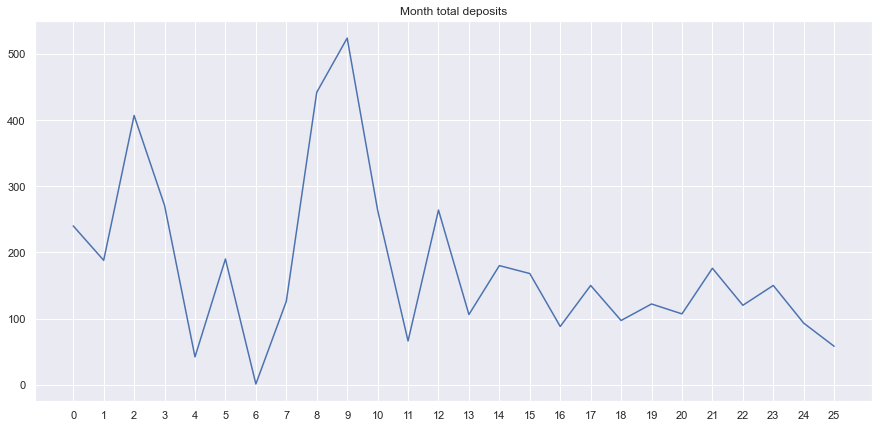

In [271]:
fig = plt.figure(figsize=(15, 7))
plt.plot(bank_data.groupby(['ts_month'])['y'].sum())
plt.xticks(np.arange(26))
plt.title('Month total deposits')

### Modeling

In [ ]:
def encode_categorical(features, data):
    for feature in features:
        data = pd.concat([data.drop(feature, axis=1), pd.get_dummies(data[feature], prefix=feature, prefix_sep='_',
                                                                     drop_first=True, dummy_na=False)], axis=1)
    display(data.sample(5))
    return data
        
        
cat_features = ['job', 'marital', 'education', 'contact', 'month', 'poutcome']
bank_data = encode_categorical(cat_features, bank_data)

In [53]:
X = bank_data.drop(columns='y')
y = bank_data['y']

rf = RandomForestClassifier(n_estimators=500)

scoring = {'accuracy': 'accuracy', 'recall': 'recall'}
scores = cross_validate(rf, X, y, scoring=scoring, cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                        return_train_score=True)
sorted(scores.keys())

['fit_time',
 'score_time',
 'test_accuracy',
 'test_recal',
 'train_accuracy',
 'train_recal']

In [55]:
print('Train accuracy: ', scores['train_accuracy'])
print('Valid accuracy: ', scores['test_accuracy'])
print('Train recall: ', scores['train_recall'])
print('Valid recall: ', scores['test_recall'])

Train accuracy:  [1. 1. 1. 1. 1.]
Valid accuracy:  [0.90777397 0.90311878 0.90510949 0.91108162 0.90433532]
Train recall:  [1. 1. 1. 1. 1.]
Valid recall:  [0.40642722 0.39167455 0.40642722 0.40453686 0.4026465 ]
